<font size = "5"> **Chapter 2: [Diffraction](../Diffraction/CH2_00-Diffraction.ipynb)** </font>

<hr style="height:1px;border-top:4px solid #FF8200" />

#  Homework 4

<font size = "5"> Analyzing Ring Diffraction Pattern </font>

[Download](https://raw.githubusercontent.com/gduscher/MSE672-Introduction-to-TEM//main/Homework/Homework04.ipynb)


[![OpenInColab](https://colab.research.google.com/assets/colab-badge.svg)](
    https://colab.research.google.com/github/gduscher/MSE672-Introduction-to-TEM/blob/main/Homework/Homework04.ipynb)


part of 

<font size = "5"> **[MSE672:  Introduction to Transmission Electron Microscopy](../_MSE672_Intro_TEM.ipynb)**</font>

by Gerd Duscher, Spring 2025

Microscopy Facilities<br>
Institute of Advanced Materials & Manufacturing<br>
Materials Science & Engineering<br>
The University of Tennessee, Knoxville

Background and methods to analysis and quantification of data acquired with transmission electron microscopes.


## Overview
This homework follows the notebook:
[Analyzing Ring Diffraction Pattern](../Diffraction/CH2_05-Diffraction_Rings.ipynb)


## Load relevant python packages
### Check Installed Packages

In [ ]:
import sys
from pkg_resources import get_distribution, DistributionNotFound

def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = get_distribution(package_name).version
    except (DistributionNotFound, ImportError) as err:
        version = '-1'
    return version

if test_package('pyTEMlib') < '0.2025.1.0':
    print('installing pyTEMlib')
    !{sys.executable} -m pip install  --upgrade pyTEMlib
print('done')

### Load the plotting and figure packages
Import the python packages that we will use:

Beside the basic numerical (numpy) and plotting (pylab of matplotlib) libraries,
* three dimensional plotting
and some libraries from the book
* kinematic scattering library.

In [1]:
%matplotlib  widget
import matplotlib.pyplot as plt
import numpy as np

# 3D and selection plotting package 
from mpl_toolkits.mplot3d import Axes3D # 3D plotting
from matplotlib.widgets import  EllipseSelector


# additional package 
import itertools 
import scipy.constants as const
import os
import sys

if 'google.colab' in sys.modules:
    from google.colab import output
    output.enable_custom_widget_manager()
    from google.colab import drive

# Import libraries from the book
import pyTEMlib
import pyTEMlib.kinematic_scattering as ks         # Kinematic sCattering Library
                             # with Atomic form factors from Kirklands book
import pyTEMlib.file_tools as ft     

# it is a good idea to show the version numbers at this point for archiving reasons.
__notebook_version__ = '2025.02.10'

print('pyTEM version: ', pyTEMlib.__version__)
print('notebook version: ', __notebook_version__)

You don't have igor2 installed.     If you wish to open igor files, you will need to install it     (pip install igor2) before attempting.
You don't have gwyfile installed.     If you wish to open .gwy files, you will need to      install it (pip install gwyfile) before attempting.
Symmetry functions of spglib enabled
Using kinematic_scattering library version {_version_ }  by G.Duscher
pyTEM version:  0.2024.09.0
notebook version:  2025.02.10



## Load Ring-Diffraction Pattern


### First we select the diffraction pattern

In the second lab we used a sample of polycrystalline Aluminium. 

If you run this notebook on your own computer you should download your images from the [google drive for 2025 Lab Data](https://drive.google.com/drive/folders/1jZKyvi9r9gUcF5XD-D69MX5foZKHi3yN?usp=drive_link), if you run it on google colab you can go to the drive directory in the dialog below. 

Download your images from the google drive at https://drive.google.com/drive/folders/1TId7PiGUbip8m8JgX2FL5PaNjld1idzt?usp=sharing

> You must log into Google with your UTK account to be able to read these data.
>

Go to the folder of you data and select one  


In [4]:
if 'google.colab' in sys.modules:
    drive.mount("/content/drive")
fileWidget = ft.FileWidget()

alpha tilt 0.01°
beta tilt 0.00°


sidpy.Dataset of type IMAGE with:
 dask.array<array, shape=(1024, 1024), dtype=float64, chunksize=(1024, 1024), chunktype=numpy.ndarray>
 data contains: intensity (counts)
 and Dimensions: 
u:  reciprocal distance (1/nm) of size (1024,)
v:  reciprocal distance (1/nm) of size (1024,)
 with metadata: ['experiment']

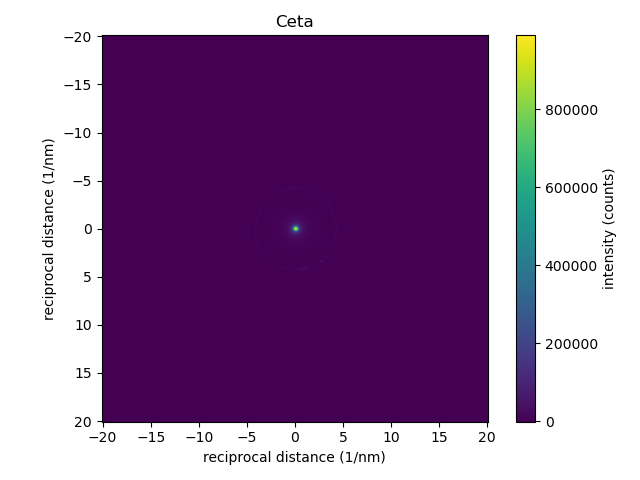

In [3]:
diff_pattern = fileWidget.selected_dataset
print(f"alpha tilt {np.degrees(diff_pattern.metadata['experiment']['stage']['tilt']['alpha']):.2f}°")  
print(f"beta tilt {np.degrees(diff_pattern.metadata['experiment']['stage']['tilt']['beta']):.2f}°")  
view = diff_pattern.plot()

diff_pattern

## Finding the center

### Select the center yourself
Select the center of the screen with the ellipse selection tool

Note: we use the logarithm to plot the diffraction pattern (look for : "np.log"  in the code cell below, the number that follows is the gamma value, change it)

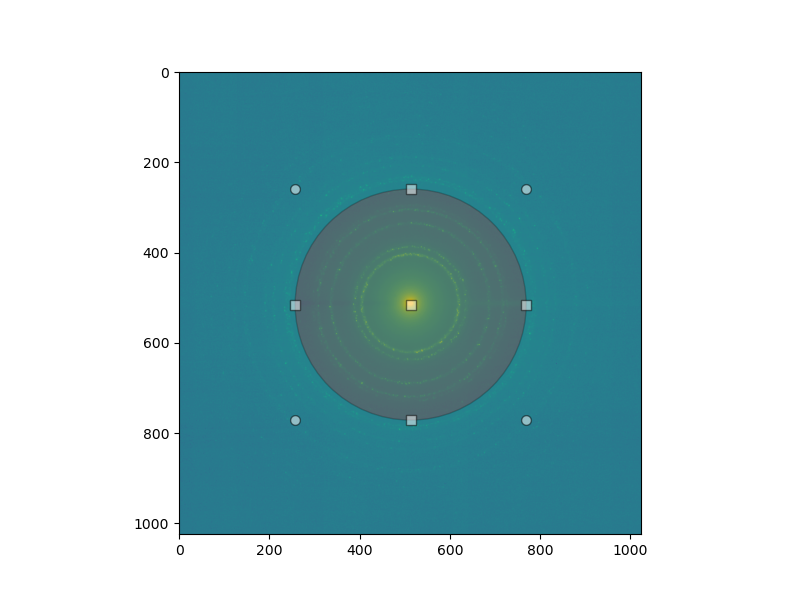

In [5]:
## Access the data of the loaded image

#diff_pattern = np.array(main_dataset.sum(axis=0))
diff_pattern = diff_pattern-diff_pattern.min()
radius =  diff_pattern.shape[1]/4
center = np.array([diff_pattern.shape[0]/2, diff_pattern.shape[1]/2])

center= np.unravel_index(np.argmax(np.array(diff_pattern), axis=None), diff_pattern.shape)


plt.figure(figsize=(8, 6))
plt.imshow(np.log(3.+diff_pattern).T, origin = 'upper')
current_axis = plt.gca()
selector = EllipseSelector(current_axis, 
                           None,
                           interactive=True , 
                           minspanx=5, minspany=5,
                           spancoords='pixels')  # gca get current axis (plot)

center = np.array(center)

selector.extents = (center[0]-radius,center[0]+radius,center[1]-radius,center[1]+radius)

plt.show()

Get center coordinates from selection

In [6]:
xmin, xmax, ymin, ymax = selector.extents
x_center, y_center = selector.center
x_shift = x_center - diff_pattern.shape[0]/2
y_shift = y_center - diff_pattern.shape[1]/2
print(f'radius = {(xmax-xmin)/2:.0f} pixels')

center = (x_center, y_center )
print(f'new center = {center} [pixels]')

out_tags ={}
out_tags['center'] = center

radius = 256 pixels
new center = (513.0, 515.0) [pixels]


## Ploting Diffraction Pattern in Polar Coordinates

### The Transformation Routine

In [7]:
from scipy.interpolate import interp1d
from scipy.ndimage import map_coordinates


def cartesian2polar(x, y, grid, r, t, order=3):

    R,T = np.meshgrid(r, t)

    new_x = R*np.cos(T)
    new_y = R*np.sin(T)

    ix = interp1d(x, np.arange(len(x)))
    iy = interp1d(y, np.arange(len(y)))

    new_ix = ix(new_x.ravel())
    new_iy = iy(new_y.ravel())

    
    return map_coordinates(grid, np.array([new_ix, new_iy]),
                            order=order).reshape(new_x.shape)

def warp(diff,center):
    # Define original polar grid
    nx = diff.shape[0]
    ny = diff.shape[1]

    x = np.linspace(1, nx, nx, endpoint = True)-center[0]
    y = np.linspace(1, ny, ny, endpoint = True)-center[1]
    z = diff

    # Define new polar grid
    nr = int(min([center[0], center[1], diff.shape[0]-center[0], diff.shape[1]-center[1]])-1)
    print(nr)
    nt = 360*3


    r = np.linspace(1, nr, nr)
    t = np.linspace(0., np.pi, nt, endpoint = False)
    return cartesian2polar(x,y, z, r, t, order=3).T

### Now we transform

If the center is correct a ring in carthesian coordinates is a line in polar coordinates

A simple sum over all angles gives us then the diffraction profile (intensity profile of diffraction pattern)


508


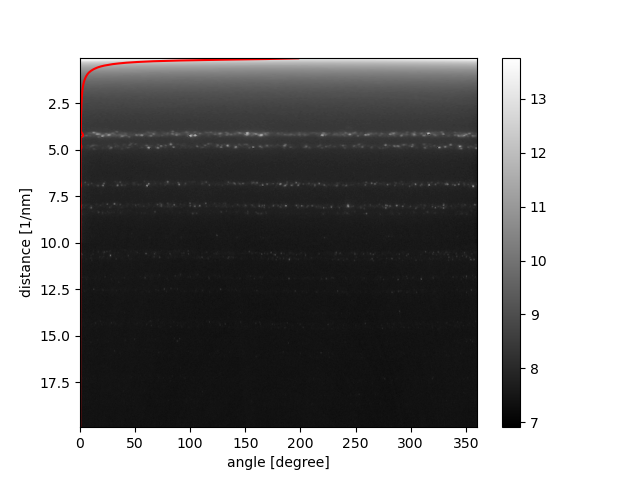

In [8]:
center = np.array(center)
out_tags={'center': center}

polar_projection = warp(diff_pattern,center)
below_zero = polar_projection<0.
polar_projection[below_zero]=0.

out_tags['polar_projection'] = polar_projection

# Sum over all angles (axis 1)
profile = polar_projection.sum(axis=1)

out_tags['radial_average'] = profile

scale = ft.get_slope(diff_pattern.dim_0.values)

plt.figure()
im = plt.imshow(np.log(1000+polar_projection),extent=(0,360,polar_projection.shape[0]*scale,scale),cmap="gray")# , vmin=np.max(np.log2(1+diff_pattern))*0.5)
plt.colorbar(im)
ax = plt.gca()
ax.set_aspect("auto");
plt.xlabel('angle [degree]');
plt.ylabel('distance [1/nm]')

plt.plot(profile/profile.max()*200,np.linspace(1,len(profile),len(profile))*scale,c='r');


In the image above check: 
- Are the lines straight?
  
## Determine Bragg Peak

Peak finding is actually not as simple as it looks

Peaks are at pixels:
[107 122 174 204 269 304 320 349 366 390 406 441 462 475 492]


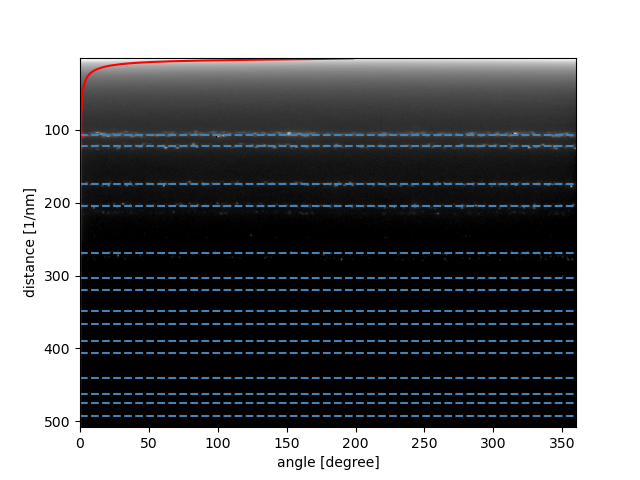

In [9]:
# --- Input ------
scale = 1. 
# ----------------
import scipy as sp
import scipy.signal as signal



# find_Bragg peaks in profile
peaks, g= signal.find_peaks(profile,rel_height =1.1, width=7)  # np.std(second_deriv)*9)

print('Peaks are at pixels:')
print(peaks)

out_tags['ring_radii_px'] = peaks


plt.figure()

plt.imshow(np.log2(1.+polar_projection),extent=(0,360,polar_projection.shape[0]*scale,scale),cmap='gray', vmin=np.max(np.log2(1+diff_pattern))*0.5)

ax = plt.gca()
ax.set_aspect("auto");
plt.xlabel('angle [degree]');
plt.ylabel('distance [1/nm]')

plt.plot(profile/profile.max()*200,np.linspace(1,len(profile),len(profile))*scale,c='r');

for i in peaks:
    if i*scale > 3.5:
        plt.plot((0,360),(i*scale,i*scale), linestyle='--', c = 'steelblue')

## Calculate Ring Pattern

> Note that you will need to change the material


see [Structure Factors notebook ](CH2_04-Structure_Factors.ipynb) for details.

In [10]:
# -------Input  -----
material = 'gold'
# -------------------

# Initialize the dictionary with all the input
atoms = ks.structure_by_name(material)

#ft.h5_add_crystal_structure(main_dataset.h5_dataset.file, atoms)


#Reciprocal Lattice 
# We use the linear algebra package of numpy to invert the unit_cell \"matrix\"
reciprocal_unit_cell = atoms.cell.reciprocal() # transposed of inverted unit_cell

#INPUT
hkl_max = 7#  maximum allowed Miller index

acceleration_voltage = 200.0 *1000.0 #V
wave_length  = ks.get_wavelength(acceleration_voltage)



h  = np.linspace(-hkl_max,hkl_max,2*hkl_max+1)   # all to be evaluated single Miller Index
hkl  = np.array(list(itertools.product(h,h,h) )) # all to be evaluated Miller indices
g_hkl = np.dot(hkl,reciprocal_unit_cell)  

# Calculate Structure Factors

structure_factors = []

base = atoms.positions # in Carthesian coordinates
for j  in range(len(g_hkl)):
    F = 0
    for b in range(len(base)):
        f = ks.feq(atoms[b].symbol,np.linalg.norm(g_hkl[j])) # Atomic form factor for element and momentum change (g vector)
        F += f * np.exp(-2*np.pi*1j*(g_hkl[j]*base[b]).sum())        
    structure_factors.append(F)
F = structure_factors = np.array(structure_factors)

# Allowed reflections have a non zero structure factor F (with a  bit of numerical error)
allowed = np.absolute(structure_factors) > 0.001

distances = np.linalg.norm(g_hkl, axis = 1)

print(f' Of the evaluated {hkl.shape[0]} Miller indices {allowed.sum()} are allowed. ')
# We select now all the 
zero = distances == 0.
allowed = np.logical_and(allowed,np.logical_not(zero))

F = F[allowed]
g_hkl = g_hkl[allowed]
hkl = hkl[allowed]
distances = distances[allowed]

sorted_allowed = np.argsort(distances)

distances = distances[sorted_allowed]
hkl = hkl[sorted_allowed]
F = F[sorted_allowed]

# How many have unique distances and what is their muliplicity

unique, indices  = np.unique(distances, return_index=True)

print(f' Of the {allowed.sum()} allowed Bragg reflections there are {len(unique)} families of reflections.')

intensity = np.absolute(F[indices]**2*(np.roll(indices,-1)-indices))
print('\n index \t  hkl \t      1/d [1/Ang]       d [pm]     F      multip.  intensity' )
family = []
#out_tags['reflections'] = {}
reflection = 0
for j in range(len(unique)-1):
    i = indices[j]    
    i2 = indices[j+1]   
    family.append(hkl[i+np.argmax(hkl[i:i2].sum(axis=1))])
    index = '{'+f'{family[j][0]:.0f} {family[j][1]:.0f} {family[j][2]:.0f}'+'}'
    print(f'{i:3g}\t {index} \t  {distances[i]:.4f}  \t {1/distances[i]*100:.0f} \t {np.absolute(F[i]):4.2f} \t  {indices[j+1]-indices[j]:3g} \t {intensity[j]:.2f}') 
    #out_tags['reflections'+str(reflection)]={}
    out_tags['reflections-'+str(reflection)+'-index'] = index
    out_tags['reflections-'+str(reflection)+'-recip_distances'] = distances[i]
    out_tags['reflections-'+str(reflection)+'-structure_factor'] = np.absolute(F[i])
    out_tags['reflections-'+str(reflection)+'-multiplicity'] = indices[j+1]-indices[j]
    out_tags['reflections-'+str(reflection)+'-intensity'] = intensity[j]
    reflection +=1

 Of the evaluated 3375 Miller indices 855 are allowed. 
 Of the 854 allowed Bragg reflections there are 39 families of reflections.

 index 	  hkl 	      1/d [1/Ang]       d [pm]     F      multip.  intensity
  0	 {1 1 1} 	  0.4247  	 235 	 27.00 	    8 	 5832.86
  8	 {0 0 2} 	  0.4904  	 204 	 24.48 	    6 	 3596.79
 14	 {0 2 2} 	  0.6935  	 144 	 18.27 	   12 	 4004.58
 26	 {1 1 3} 	  0.8133  	 123 	 15.54 	    8 	 1930.91
 34	 {1 3 1} 	  0.8133  	 123 	 15.54 	   16 	 3861.82
 50	 {2 2 2} 	  0.8494  	 118 	 14.82 	    8 	 1756.96
 58	 {0 0 4} 	  0.9808  	 102 	 12.57 	    6 	 948.09
 64	 {3 3 1} 	  1.0688  	 94 	 11.33 	    8 	 1026.40
 72	 {3 1 3} 	  1.0688  	 94 	 11.33 	   16 	 2052.80
 88	 {4 0 2} 	  1.0966  	 91 	 10.97 	   24 	 2889.10
112	 {2 2 4} 	  1.2013  	 83 	 9.77 	   24 	 2291.50
136	 {5 1 1} 	  1.2741  	 78 	 9.05 	   16 	 1310.07
152	 {3 3 3} 	  1.2741  	 78 	 9.05 	   16 	 1310.07
168	 {0 4 4} 	  1.3871  	 72 	 8.08 	   12 	 783.51
180	 {1 5 3} 	  1.4507  	 69 	 7.6

## Comparison
Comparison between experimental profile and kinematic theory

The grain size will have an influence on the width of the diffraction rings"

In [ ]:
# -------Input of grain size ----
first_peak_pixel = 100
first_peak_reciprocal_distance = 0.4247
pixel_size = first_peak_reciprocal_distance/first_peak_pixel
resolution  = 0 # 1/nm
thickness = 100 # Ang
# -------------------------------

print(f'Pixel size is {pixel_size:.5f} 1/Ang')
from scipy import signal

width = (1/thickness + resolution) / scale
# scale = ft.get_slope(main_dataset.dim_0.values)  *1.085*1.0/10
scale = pixel_size
intensity2 = intensity/intensity.max()*10

gauss = signal.windows.gaussian(len(profile), std=width)
simulated_profile = np.zeros(len(profile))
rec_dist = np.linspace(1,len(profile),len(profile))*pixel_size


plt.figure()
plt.plot(rec_dist,profile/profile.max()*150, color='blue', label='experiment');
for j in range(len(unique)-1):
    if unique[j] < len(profile)*scale:
        # plot lines
        plt.plot([unique[j],unique[j]], [0, intensity2[j]],c='r')
        # plot indices
        index = '{'+f'{family[j][0]:.0f} {family[j][1]:.0f} {family[j][2]:.0f}'+'}' # pretty index string
        plt.text(unique[j],-3, index, horizontalalignment='center',
              verticalalignment='top', rotation = 'vertical', fontsize=8, color = 'red')
        
        # place Gaussian with appropriate width in profile
        g = np.roll(gauss,int(-len(profile)/2+unique[j]/scale))* intensity2[j]*10#rec_dist**2*10
        simulated_profile = simulated_profile + g
plt.plot(np.linspace(1,len(profile),len(profile))*scale,simulated_profile/50, label='simulated');
plt.xlabel('angle (1/$\AA$)')
plt.legend()
plt.ylim(-.5,10)


## Publication Quality Output

Now we have all the ingredients to make a publication quality plot of the data.

In [ ]:
from matplotlib import patches

plot_profile = profile.copy()
plot_profile[:first_peak_pixel-20] = 0
fig = plt.figure(figsize=(9, 6)) 

extent= np.array([-center[0], diff_pattern.shape[0]-center[0],-diff_pattern.shape[1]+center[1], center[1]])*scale

plt.imshow(np.log(3.+diff_pattern).T,cmap='gray', extent=(extent*1.0)) #, vmin=np.max(np.log2(1+diff_pattern))*0.5)
plt.xlabel(r'reciprocal distance [nm$^{-1}$]')
ax = fig.gca()
#ax.add_artist(circle1);
plt.plot(np.linspace(1,len(profile),len(profile))*scale,plot_profile/plot_profile.max(), color='y');
plt.plot((0,len(profile)*scale),(0,0),c='r')

for j in range(len(unique)-1):
    i = indices[j]   
    if distances[i] < len(profile)*scale:
        plt.plot([distances[i],distances[i]], [0, intensity2[j]/20],c='r')
        arc = patches.Arc((0,0), distances[i]*2, distances[i]*2, angle=90.0, theta1=0.0, theta2=270.0, color='r', fill= False, alpha = 0.5)#, **kwargs)
        ax.add_artist(arc);
plt.scatter(0,0);

for i in range(6):
    index = '{'+f'{family[i][0]:.0f} {family[i][1]:.0f} {family[i][2]:.0f}'+'}' # pretty index string
    plt.text(unique[i],-0.05, index, horizontalalignment='center',
             verticalalignment='top', rotation = 'vertical', fontsize=8, color = 'white')

## Homework

Determine the pixel_size and for two different indicated camera lengths!

Submit one notebook with your diffraction pattern

**Optional:**
> Plot the indicated camera length over the pixel size!
